In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-tweets/Bitcoin_tweets.csv


# Data preparation

In [2]:
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
from scipy import stats as stat

In [3]:
df_path = "../input/bitcoin-tweets/Bitcoin_tweets.csv"
df = pd.read_csv(df_path)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


dropping columns we won't use :

In [4]:
df.drop(["user_name","user_description", "user_created","user_location"], axis=1, inplace=True)
df.drop(df.loc[df.user_verified.isna()].index, axis=0, inplace=True)

We transform the Hashtags column to have clean arrays we can work with :

In [5]:
df["hashtags"]=df["hashtags"].apply(lambda s : s[1:-1].split(',') if isinstance(s,str) else [])
df["hashtags_len"]=df["hashtags"].apply(len)

We convert columns to float to be able to work with them :

In [6]:
def conv_to_int(val):
    if isinstance(val, str):
        return 0
    else:
        return float(val)
df["user_followers"]=df["user_followers"].apply(lambda x : conv_to_int(x))
df["user_friends"]=df["user_friends"].apply(lambda x : conv_to_int(x))
df["user_favourites"]=df["user_favourites"].apply(lambda x : conv_to_int(x))

We remove all "#" from our text : 

In [7]:
def clean_text(text):
    if(isinstance(text, str)):
        text = text.replace("#","")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""

df["clean_text"]=df["text"].apply(clean_text)
df.drop("text", axis=1, inplace=True)

We transform dates too :

In [8]:
df["date"]=pd.to_datetime(df["date"],errors='coerce')
df["date"]=df["date"].apply(lambda x: x.date() )

Just for fun, we can guess an impact score for each tweet based on the information we have :

In [17]:
def generate_impact_score(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1+(tweet.hashtags_len/20)
    return ((tweet.user_followers + (tweet.user_friends/4))*coef_verified*coef_hashtags)/100

In [18]:
df["impact_score"]=df.apply(generate_impact_score, axis=1)

Importing BTC stocks info from yahoo finance :

In [11]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23909 sha256=13871b8dca2ce2ac602fa2ee6af380cdc575c75ecd973f040ca4d9b415f86c82
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=a64ae88f0a11297ac6b0a3b8e87a080035ca7446f4f7d377d01417af55fdcea1
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking


In [19]:
import yfinance as yf
btc_stock=yf.Ticker("BTC-USD")

In [20]:
start = min(df['date'])
end = max(df['date'])
btc_stock = btc_stock.history(start=start, end=end)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  


# Does tweets volume affects BTC traded volume ?

Hypothesis : tweets amount affects the volume traded of the particular company. 
To verify that, we shift the entire timeseries back by 1 period, to compare the effects of tweets from day before on the btc  traded volume the following day.

Spearman correlation statistic test was used (it does not assume that the dataset is normally distributed).

If the p-value of the spearman correlation, falls below the pre-determined threshold of 0.05, we will reject the null hypothesis and we will have enough evidence to conclude that there is a correlation between the btc traded volume and the amount of tweets.


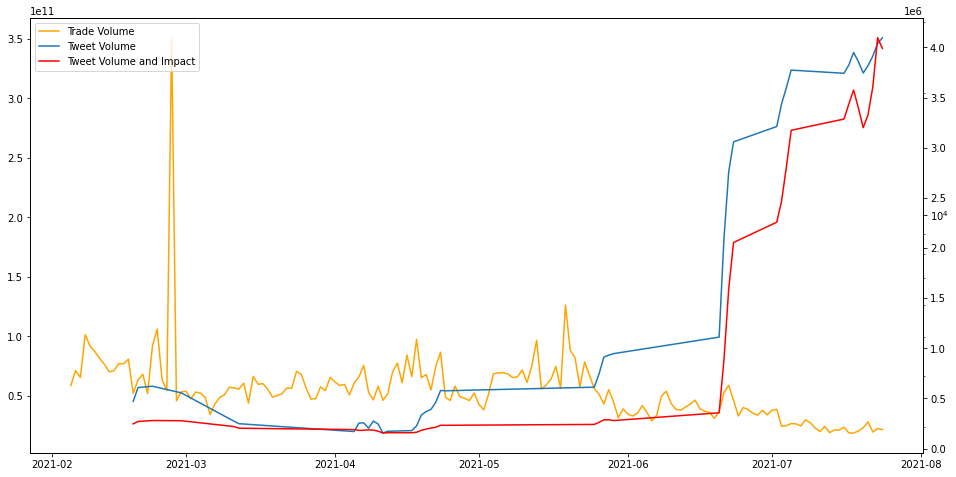

Spearman correlation - tweets: corr=-0.52625 pval=0.00006
Spearman correlation - impact tweets: corr=-0.54452 pval=0.00003


In [21]:
tweet_shift1 = df.groupby('date').size().shift(-1).dropna() 
tweet_shift1_impact = df.groupby('date')["impact_score"].sum().shift(-1).dropna() 

stocks_data = btc_stock['Volume'].dropna()

corr, pval = stat.spearmanr(tweet_shift1.reindex(stock_data.index), stock_data,nan_policy='omit')
corr_i, pval_i = stat.spearmanr(tweet_shift1_impact.reindex(stock_data.index), stock_data,nan_policy='omit')

tweets_vol = df.groupby('date').size().rolling(10).mean().dropna()
tweets_vol_impact= df.groupby('date')["impact_score"].sum().rolling(10).mean().dropna()

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(stocks_data.index,stocks_data,color='orange',label='Trade Volume')
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2.plot(tweets_vol.index,tweets_vol,label='Tweet Volume')
ax2.set_yscale('log')
ax2.tick_params(axis='y')

ax3=ax.twinx()
ax3.plot(tweets_vol_impact.index,tweets_vol_impact,label='Tweet Volume and Impact', color='red')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=0)

plt.show()

print("Spearman correlation - tweets: corr={} pval={}".format(corr,pval))
print("Spearman correlation - impact tweets: corr={} pval={}".format(corr_i,pval_i))


# Sentiment analysis 

We want to run our analysis again, this time taking into account the tweets' sentiments.

**Reminder :**
* positive sentiment : (compound score >= 0.05) 
* neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
* negative sentiment : (compound score <= -0.05)

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer

def get_polarity_score(tweet):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(tweet)["compound"]
    
def get_polarity_cat(score):
    if score >=0.05 : 
        return "positive"
    elif score <=-0.05:
        return "negative"
    else:
        return "neutral"

df["polarity_score"]=df["clean_text"].apply(get_polarity_score)
df["polarity_cat"]=df["polarity_score"].apply(get_polarity_cat)

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [23]:
df.head()

,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_retweet,hashtags_len,clean_text,impact_score,polarity_score,polarity_cat
0,8534.0,0.0,0.0,False,2021-02-10,['bitcoin'],Twitter Web App,False,1,Blue Ridge Bank shares halted by NYSE after bi...,98.56770,0.2960,positive
1,6769.0,0.0,0.0,False,2021-02-10,"['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,4,"😎 Today, that's this Thursday, we will do a ""🎬...",89.35080,0.6808,positive
2,128.0,0.0,0.0,False,2021-02-10,[],Twitter Web App,False,0,"Guys evening, I have read this article about B...",1.40800,0.5719,positive
3,625.0,0.0,0.0,False,2021-02-10,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,4,$BTC A big chance in a billion! Price: \487264...,8.25000,0.3164,positive
4,1249.0,0.0,0.0,False,2021-02-10,['BTC'],Twitter Web App,False,1,This network is secured by 9 508 nodes as of t...,14.42595,0.4019,positive


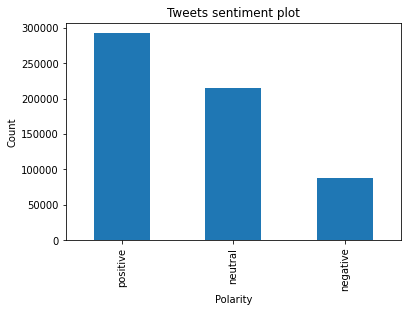

In [24]:
df['polarity_cat'].value_counts().plot(kind="bar")
plt.title("Tweets sentiment plot")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.show()

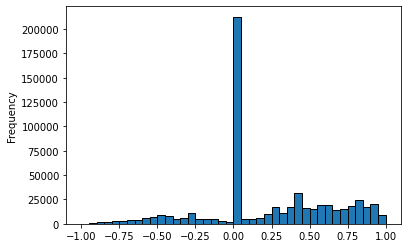

In [41]:
df.polarity_score.plot(kind='hist',range=(-1,1),bins=40,edgecolor='black');

In [26]:
df_positive=df.loc[df.polarity_cat=="positive"]
df_negative=df.loc[df.polarity_cat=="negative"]
df_neutral=df.loc[df.polarity_cat=="neutral"]

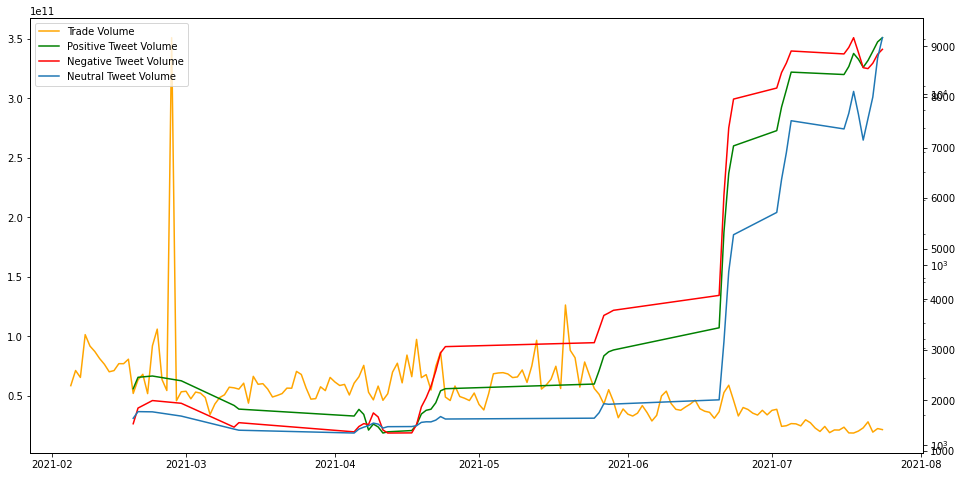

Spearman correlation - tweets: corr=-0.5288141381371126 pval=5.574995473482732e-05
Spearman correlation - tweets: corr=-0.5311732941808873 pval=5.0906403032778656e-05
Spearman correlation - tweets: corr=-0.5286546713120718 pval=5.609214779526541e-05


In [68]:
tweet_shift_positive = df_positive.groupby('date').size().shift(-1) 
tweet_shift_negative = df_negative.groupby('date').size().shift(-1) 
tweet_shift_neutral = df_neutral.groupby('date').size().shift(-1)

stocks_data = btc_stock['Volume'].dropna()

corr_positive, pval_positive = stat.spearmanr(tweet_shift_positive.reindex(stock_data.index), stocks_data,nan_policy='omit')
corr_negative, pval_negative = stat.spearmanr(tweet_shift_negative.reindex(stock_data.index), stocks_data,nan_policy='omit')
corr_neutral, pval_neutral = stat.spearmanr(tweet_shift_neutral.reindex(stock_data.index), stocks_data,nan_policy='omit')

tweets_vol_positive = df_positive.groupby('date').size().rolling(10).mean()
tweets_vol_negative = df_negative.groupby('date').size().rolling(10).mean()
tweets_vol_neutral = df_neutral.groupby('date').size().rolling(10).mean()

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(stocks_data.index,stocks_data,color='orange',label='Trade Volume')
ax3.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(tweets_vol_positive.index,tweets_vol_positive,label='Positive Tweet Volume', color="green")
ax2.set_yscale('log')
ax2.tick_params(axis='y')

ax3 = ax.twinx()
ax3.plot(tweets_vol_negative.index,tweets_vol_negative,label='Negative Tweet Volume', color="red")
ax3.set_yscale('log')

ax4 = ax.twinx()
ax4.plot(tweets_vol_neutral.index,tweets_vol_neutral,label='Neutral Tweet Volume')
ax4.tick_params(axis='y')
ax3.set_yscale('log')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3 + lines4, labels + labels2 + labels3 + labels4, loc=0)

plt.show()

print("Spearman correlation - tweets: corr={} pval={}".format(corr_positive,pval_positive))
print("Spearman correlation - tweets: corr={} pval={}".format(corr_negative,pval_negative))
print("Spearman correlation - tweets: corr={} pval={}".format(corr_neutral,pval_neutral))


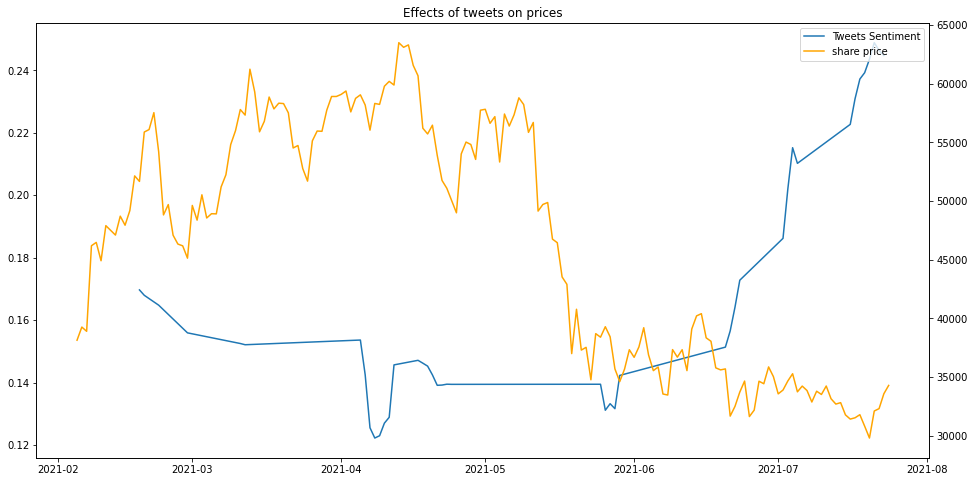

Spearman correlation: corr=-0.56732 pval=0.00001


In [51]:
sentiment= df.groupby('date')['polarity_score'].mean().shift(-1).rolling(10).mean()
corr_test = df.groupby('date')['polarity_score'].mean().shift(-1)
corr, pval = stat.spearmanr(corr_test.reindex(btc_stock.index), btc_stock['Open'],nan_policy='omit')

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(sentiment.index,sentiment,label='Tweets Sentiment score')
ax2 = ax.twinx()
ax2.plot(btc_stock.index,btc_stock['Close'],color='orange',label='share price')
ax2.set_title("Effects of tweets on prices")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

print("Spearman correlation: corr={} pval={}".format(corr,pval))